# CS549 Machine Learning - Irfan Khan
# Assignment 10: Recurrent Neural Network


**Total points: 10**

In this assignment, we will implement basic RNN and an LSTM based RNN. For the final submission, do a kernel->Restart and Clear Output. Then run each cell sequentially from the beginning to the end.
https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html

# Import Needed Libraries

In [13]:
from io import open
import glob
import os
import unicodedata
import random
import string
import torch
import numpy as np
import time
import math

# Data

The folder data has text files one for each language. 18 languages/folders.
Convert from UniCode to ASCII. No additional code needed.

In [14]:
#random.seed(0)
def findFiles(path): return glob.glob(path)
print(findFiles('*.txt'))
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)
print ('n_letters',n_letters)
# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )
print(unicodeToAscii('Ślusàrski'))
# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []
# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]
for filename in findFiles('*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines
n_categories = len(all_categories)
print ('n_categories', n_categories)
#print ('category_lines', category_lines)

['eng-fra.txt', 'Arabic.txt', 'Japanese.txt', 'Czech.txt', 'Portuguese.txt', 'Russian.txt', 'Italian.txt', 'Dutch.txt', 'Vietnamese.txt', 'German.txt', 'Polish.txt', 'Chinese.txt', 'Irish.txt', 'Scottish.txt', 'Korean.txt', 'Spanish.txt', 'English.txt', 'French.txt', 'Greek.txt']
n_letters 57
Slusarski
n_categories 19


# Test - print list of 5 names in a supported language (Arabic, Chinese, etc.)

In [15]:
#Test Data Prep

print(category_lines['Spanish'][:5])

['Abana', 'Abano', 'Abarca', 'Abaroa', 'Abascal']


# Names -> Tensors

To represent a single letter, we use a “one-hot vector” of size <1 x n_letters>. A one-hot vector is filled with 0s except for a 1 at index of the current letter, e.g. "b" = <0 1 0 0 0 ...>.

To make a word we join a bunch of those into a 2D matrix <line_length x 1 x n_letters>.

That extra 1 dimension is because PyTorch assumes everything is in batches - we’re just using a batch size of 1 here. No additional code needed.


In [16]:
#random.seed(0)
# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


# Section 1 Basic RNN

No code needed - provided as example - don't change

# Defining the RNN
This RNN module (mostly copied from the PyTorch for Torch users tutorial) is just 2 linear layers (1 hidden layer + 1 output layer) which operate on an input and hidden state with a tanh activation function, with a LogSoftmax layer after the output. Hidden Layer activation $a^{<t>}$ is a 128 element vector

In [17]:
import torch.nn as nn

class Basic_RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Basic_RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.tanh=nn.Tanh()
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        hidden=self.tanh(hidden)
        output = self.h2o(hidden)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):

        return torch.zeros(1, self.hidden_size)

n_hidden = 128
basic_rnn = Basic_RNN(n_letters, n_hidden, n_categories)

# Training

# Prep for Training

This helper function interprets the output of the network, which we know to be a likelihood of each category. We can use Tensor.topk to get the index of the greatest value:

In [18]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

# Quick Way to Get a Training Example


In [19]:
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    #print (category_tensor.shape, line_tensor.shape)
    return category, line, category_tensor, line_tensor

random.seed(0)
for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Irish / line = Reynold
category = Scottish / line = Thomson
category = Vietnamese / line = Trang
category = Spanish / line = Quinones
category = German / line = Raskop
category = Chinese / line = Pei
category = English / line = Crocker
category = German / line = Faerber
category = Czech / line = Maly
category = French / line = Desjardins


# Train the Network



# Training Function


Create input and target tensors. Create a zeroed initial hidden state. Read each letter in and keep hidden state for next letter. Compare final output to target. Back-propagate. Return the output and loss. For the loss function nn.NLLLoss is appropriate, since the last layer of the RNN is nn.LogSoftmax. Use SGD optimizer.

In [20]:
learning_rate = 0.005 # If you set this too high, it might not converge. If too low,
#it might not learn. 0.005 from trial and error
criterion = nn.NLLLoss()
optimizer = torch.optim.SGD(basic_rnn.parameters(), lr = learning_rate)
def train_basic_RNN(category_tensor, line_tensor):
    hidden = basic_rnn.initHidden()
    #basic_rnn.zero_grad()
    optimizer.zero_grad()
    for i in range(line_tensor.size()[0]):
        output, hidden = basic_rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()
    optimizer.step()

    # Add parameters' gradients to their values, multiplied by learning rate
    #for p in basic_rnn.parameters():
        #p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

# Training Loop

Run the training function with a bunch of examples. Since the train function returns both the output and loss we can print its guesses and also keep track of loss for plotting. Since there are 1000s of examples we print only every print_every examples, and take an average of the loss.



In [21]:

# Set random seed for Python
random_seed = 0
random.seed(random_seed)
# Set random seed for NumPy
np.random.seed(random_seed)
# Set random seed for PyTorch
torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
n_iters = 100000
print_every = 5000
plot_every = 1000
# Keep track of losses for plotting
current_loss = 0
all_losses = []
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)
start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train_basic_RNN(category_tensor, line_tensor)
    current_loss += loss
    # Print ``iter`` number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start),
                                                loss, line, guess, correct))
    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 8s) 2.8415 Snelker / eng-fra ✗ (Czech)
10000 10% (0m 18s) 1.4030 Totolos / Greek ✓
15000 15% (0m 27s) 2.0061 Mojaikin / Arabic ✗ (Russian)
20000 20% (0m 35s) 2.0853 Schneijder / German ✗ (Dutch)
25000 25% (0m 44s) 1.5099 Acker / German ✓
30000 30% (0m 52s) 3.8996 Jvirblis / Greek ✗ (Russian)
35000 35% (1m 0s) 3.8563 Schenck / Czech ✗ (German)
40000 40% (1m 9s) 0.8278 Snyders / Dutch ✓
45000 45% (1m 17s) 0.0733 Poniros / Greek ✓
50000 50% (1m 25s) 1.1958 What are the origins of the OlympicsQuelles sont les origines des Jeux Olympiques / eng-fra ✓
55000 55% (1m 33s) 0.7428 Sortras / Greek ✓
60000 60% (1m 42s) 1.9375 Tolkien / French ✗ (German)
65000 65% (1m 50s) 6.8574 Loi / Korean ✗ (Russian)
70000 70% (1m 58s) 1.3888 Phi / Chinese ✗ (Vietnamese)
75000 75% (2m 7s) 2.2738 Brannon / English ✗ (Irish)
80000 80% (2m 15s) 0.1405 Hiratasuka / Japanese ✓
85000 85% (2m 22s) 3.1111 Duarte / French ✗ (Portuguese)
90000 90% (2m 31s) 1.6390 Nikolaou / Greek ✓
95000 95% (2m 39s) 1.2354 T

# Expected Results

You will see snapshot results and execution time after every 5000 epochs.

# Plot the Results


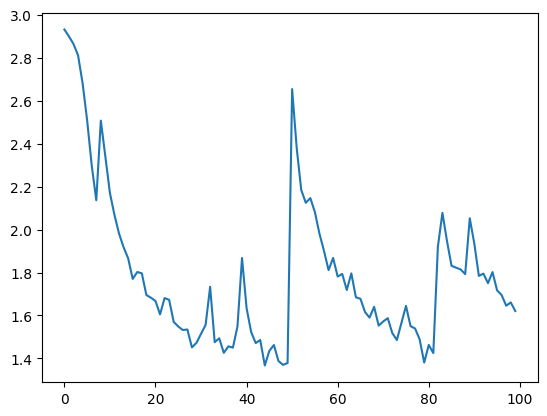

In [22]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

# Expected Result

The plot will start around 2.8, decrease and towards the end, the avg loss is about 1. Note that you have to run the cells sequentially from the beginning to get consistent results.

# Evaluate Results

To see how well the network performs on different categories, we will create a confusion matrix, indicating for every actual language (rows) which language the network guesses (columns). To calculate the confusion matrix a bunch of samples are run through the network with evaluate(), which is the same as train() minus the backprop.

<ipython-input-23-f7712bb0bfe1>:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + all_categories, rotation=90)
<ipython-input-23-f7712bb0bfe1>:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + all_categories)


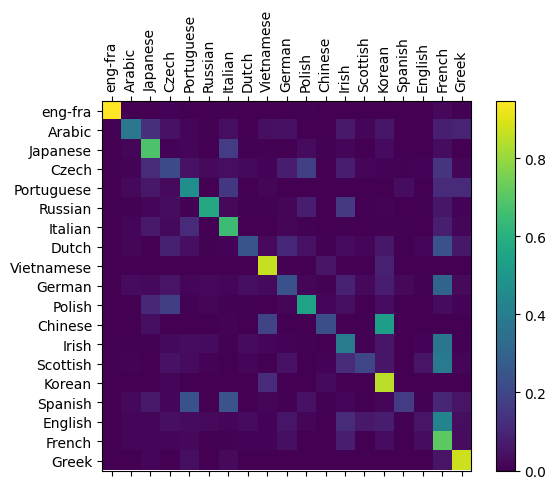

In [23]:

# Set random seed for Python
random_seed = 42
random.seed(random_seed)
# Set random seed for NumPy
np.random.seed(random_seed)
# Set random seed for PyTorch
torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000
# Just return an output given a line
def evaluate(line_tensor):
    hidden = basic_rnn.initHidden()
    for i in range(line_tensor.size()[0]):
        with torch.no_grad():
            output, hidden = basic_rnn(line_tensor[i], hidden)
    return output
# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1
# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)
# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)
# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
# sphinx_gallery_thumbnail_number = 2
plt.show()

## Expected Results

You may seem some warnings about "FixedFormatter should only be used together with FixedLocator". Ignore these. Study the confusion matrix. You can pick out bright spots off the main axis that show which languages it guesses incorrectly, e.g. Korean for Chinese, and Portugese and Spanish for Italian. It seems to do very well with Arabic, and very poorly with English (perhaps because of overlap with other languages).

# Running on User Input

Let us see what the predictions are for 4 names.

In [24]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    #with torch.no_grad():
    output = evaluate(lineToTensor(input_line))

        # Get top N categories
    topv, topi = output.topk(n_predictions, 1, True)
    predictions = []

    for i in range(n_predictions):
        value = topv[0][i].item()
        category_index = topi[0][i].item()
        print('(%.2f) %s' % (value, all_categories[category_index]))
        predictions.append([value, all_categories[category_index]])

predict ('Dostoevsky')
predict('Doveski')
predict('Jackson')
predict('Satoshi')
predict ('Giorgos')
predict ('Apostolopoulos')
predict ('Brosnan')
predict ('Connery')


> Dostoevsky
(-0.89) Russian
(-2.09) Irish
(-2.36) Czech

> Doveski
(-0.66) Polish
(-1.24) Italian
(-2.72) Japanese

> Jackson
(-1.53) Scottish
(-1.97) English
(-2.05) Greek

> Satoshi
(-0.54) Italian
(-1.72) Japanese
(-1.89) Polish

> Giorgos
(-0.12) Greek
(-3.37) Portuguese
(-4.20) Scottish

> Apostolopoulos
(-0.06) Greek
(-4.79) Polish
(-4.80) Czech

> Brosnan
(-1.48) Irish
(-1.51) Russian
(-1.59) French

> Connery
(-1.25) Irish
(-1.53) French
(-1.67) English


# Expected Results

You will see the top three predictions for each name. Number within parenthesis is the log (prob).

# Section 2 Implement and Train an LSTM RNN

**10 points**

# Define the LSTM RNN

***5 points****

Similar to the basic RNN. Here you use LSTM hidden layer instead of the basic RNN linear hidden layer. Hint: LSTM hidden states are two ($c^{<t>}$: long-term memory, $a^{<t>}$: short-term memory) compared to one in basic RNN. The output at each step is generated from $a^{<t>}$ from the last layer. Lookup the syntax for using nn.LSTM.

In [25]:
import torch.nn as nn

class LSTM_RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM_RNN, self).__init__()

        #Start your code
        # Replace nn.Linear and nn.Tanh with nn.LSTM
        self.hidden_size = hidden_size
        self.lstm = nn.LSTMCell(input_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)


        #End your code

    def forward(self, input,atminus1, htminus1):

        #Start your code
        # Forward propagate

        at, ht = self.lstm(input, (atminus1, htminus1))
        output = self.h2o(at)
        output = self.softmax(output)

        #End your code
        return output, at, ht

    def initHidden(self):
        return (torch.zeros(1, self.hidden_size), torch.zeros(1, self.hidden_size))

n_hidden = 128
lstm_rnn = LSTM_RNN(n_letters, n_hidden, n_categories)

# Training Function

****2 points****


Create input and target tensors. Create a zeroed initial hidden state. Read each letter in and keep hidden state for next letter. Compare final output to target. Back-propagate. Return the output and loss. For the loss function nn.NLLLoss is appropriate, since the last layer of the RNN is nn.LogSoftmax. Use SGD optimizer. Code needed will be similar to the regular RNN case

In [26]:
learning_rate = 0.05 # If you set this too high, it might not converge. If too low, it might not learn. 0.05 from trial and error.
criterion = nn.NLLLoss()
optimizer = torch.optim.SGD(lstm_rnn.parameters(), lr = learning_rate)
def train_LSTM_RNN(category_tensor, line_tensor):
    atminus1, htminus1 = lstm_rnn.initHidden()
#start your code

    optimizer.zero_grad()
    for i in range(line_tensor.size()[0]):
        output, atminus1, htminus1 = lstm_rnn(line_tensor[i], atminus1, htminus1)
    loss = criterion(output, category_tensor)
    loss.backward()
    optimizer.step()

#End your code

    return output, loss.item()

# Training Loop

***3 points***

Run the training function with a bunch of examples. Since the train function returns both the output and loss we can print its guesses and also keep track of loss for plotting. Since there are 1000s of examples we print only every print_every examples, and take an average of the loss. Code needed will be similar to the regular RNN case

In [27]:

# Set random seed for Python
random_seed = 0
random.seed(random_seed)
# Set random seed for NumPy
np.random.seed(random_seed)
# Set random seed for PyTorch
torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

n_iters = 100000
print_every = 5000

plot_every = 1000
# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    #Start your code
    #Get training data samples from randomTrainingExample, then use train_LSTM_RNN to
    #obtain output and loss, accumulate loss in current_loss


    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train_LSTM_RNN(category_tensor, line_tensor)
    current_loss += loss

    #End your code

    # Print ``iter`` number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start),
                                                loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 17s) 2.1834 Snelker / Russian ✗ (Czech)
10000 10% (0m 34s) 3.2770 Totolos / Scottish ✗ (Greek)
15000 15% (0m 51s) 0.8787 Mojaikin / Russian ✓
20000 20% (1m 8s) 1.4818 Schneijder / Dutch ✓
25000 25% (1m 24s) 1.1190 Acker / German ✓
30000 30% (1m 41s) 4.8703 Jvirblis / Greek ✗ (Russian)
35000 35% (1m 58s) 3.0335 Schenck / Dutch ✗ (German)
40000 40% (2m 14s) 0.3240 Snyders / Dutch ✓
45000 45% (2m 31s) 0.0153 Poniros / Greek ✓
50000 50% (2m 49s) 0.0001 What are the origins of the OlympicsQuelles sont les origines des Jeux Olympiques / eng-fra ✓
55000 55% (3m 5s) 0.0180 Sortras / Greek ✓
60000 60% (3m 23s) 1.4611 Tolkien / German ✓
65000 65% (3m 39s) 7.8990 Loi / Chinese ✗ (Russian)
70000 70% (3m 57s) 0.1323 Phi / Vietnamese ✓
75000 75% (4m 14s) 1.4656 Brannon / English ✗ (Irish)
80000 80% (4m 31s) 0.0006 Hiratasuka / Japanese ✓
85000 85% (4m 48s) 0.0679 Duarte / Portuguese ✓
90000 90% (5m 5s) 0.0151 Nikolaou / Greek ✓
95000 95% (5m 22s) 0.4362 Tomanek / Czech ✓
100000 100% (5m 

# Expected Result

You will see snapshot results and execution time after every 5000 epochs. Slower execution compared to Basic RNN.



# Plot the Results

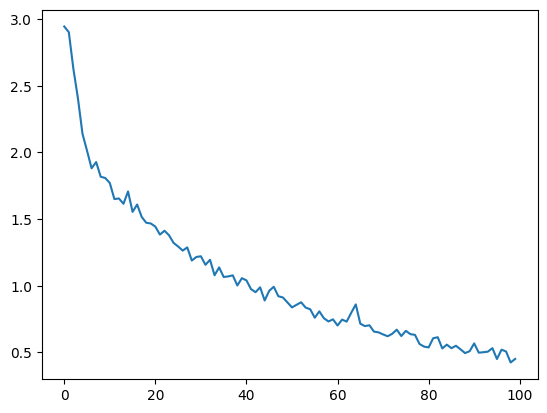

In [28]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

# Expected Result

Better performance than basic RNN. The plot will start around 2.8, decrease and towards the end, the avg loss is about 0.5. Note that you have to run the cells sequentially from the beginning to get consistent results.

# Evaluate Results
To see how well the network performs on different categories, we will create a confusion matrix, indicating for every actual language (rows) which language the network guesses (columns). To calculate the confusion matrix a bunch of samples are run through the network with evaluate(), which is the same as train() minus the backprop.

<ipython-input-29-20ee6233bbdf>:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + all_categories, rotation=90)
<ipython-input-29-20ee6233bbdf>:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + all_categories)


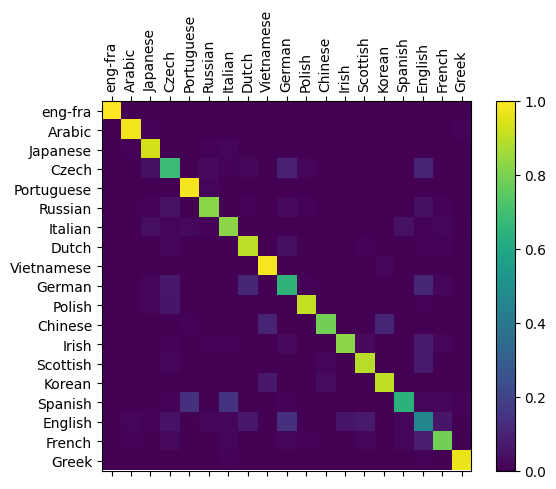

In [29]:

# Set random seed for Python
random_seed = 42
random.seed(random_seed)
# Set random seed for NumPy
np.random.seed(random_seed)
# Set random seed for PyTorch
torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000
# Just return an output given a line
def evaluate_lstm(line_tensor):
    atminus1, htminus1 = lstm_rnn.initHidden()
    for i in range(line_tensor.size()[0]):
        with torch.no_grad():
            output_lstm, at, ht = lstm_rnn(line_tensor[i], atminus1, htminus1)
            atminus1 = at
            htminus1 = ht
    return output_lstm

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output_lstm = evaluate_lstm(line_tensor)
    guess, guess_i = categoryFromOutput(output_lstm)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

# Expected Results

You may see some warnings about "FixedFormatter should only be used together with FixedLocator". Ignore these. Study the confusion matrix. It is similar to that for the basic RNN. You can pick out bright spots off the main axis that show which languages it guesses incorrectly, e.g. Chinese for Korean, and Spanish for Italian. It seems to do very well with Greek, and very poorly with English (perhaps because of overlap with other languages).

# Running on User Input

Let us predict the language for 4 names as in the regular RNN section. Could be different predictions than in the regular RNN case.

In [30]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    #with torch.no_grad():
    output_lstm = evaluate_lstm(lineToTensor(input_line))

        # Get top N categories
    topv, topi = output_lstm.topk(n_predictions, 1, True)
    predictions = []

    for i in range(n_predictions):
        value = topv[0][i].item()
        category_index = topi[0][i].item()
        print('(%.2f) %s' % (value, all_categories[category_index]))
        predictions.append([value, all_categories[category_index]])

predict ('Dostoevsky')
predict('Doveski')
predict('Jackson')
predict('Satoshi')
predict ('Giorgos')
predict ('Apostolopoulos')
predict ('Brosnan')
predict ('Connery')


> Dostoevsky
(-0.05) Russian
(-2.99) Czech
(-7.98) English

> Doveski
(-0.76) Polish
(-0.97) Czech
(-2.00) Russian

> Jackson
(-0.16) Scottish
(-1.94) English
(-7.44) Czech

> Satoshi
(-0.24) Japanese
(-1.62) Arabic
(-4.59) Italian

> Giorgos
(-1.19) Arabic
(-1.23) Greek
(-1.98) English

> Apostolopoulos
(-0.00) Greek
(-9.34) eng-fra
(-10.51) French

> Brosnan
(-0.89) Czech
(-1.64) Russian
(-1.72) English

> Connery
(-0.52) French
(-1.53) English
(-1.95) Irish


# Expected Results

You will see the top three predictions for each name. Number within parenthesis is the log (prob).

FYI:  it is generally common to use a smaller learning rate for regular RNNs compared to LSTMs. Research and practical experience have shown that LSTMs can often handle higher learning rates while still converging effectively. There are a few reasons for this:<br>
1. Gradient stability: LSTMs are designed to mitigate the vanishing gradient problem that affects regular RNNs. This allows LSTMs to handle larger learning rates without causing instability during training.<br>
2. Parameter complexity: LSTMs have more parameters and gates compared to simple RNNs. This increased complexity can make them more robust to higher learning rates.<br>
3. Long-term dependencies: LSTMs are better at capturing long-term dependencies in sequences. This capability allows them to effectively utilize information over longer time steps, even with higher learning rates.<br>